# 欢迎使用易通星云故障预测与健康管理建模向导

本文件指导用户逐步使用健康模型包对装备进行健康建模。

首先需要描述[装备健康管理的分析框架](https://mp.weixin.qq.com/s/S5qN4IphJVw2qIPwK8Cbkg)。 

一些概念:
* 状态估计: 通过传感器采集到的可观测量，对系统状态（可能是不可直接观测的量）进行估算的过程。
* 指标预测: 随着时间的推移以及外部发生事件的影响而对系统状态演进趋势的预测过程。

易通星云故障预测与健康管理软件架构图

![软件架构图](https://github.com/lvyv/prog_algs/blob/dev/demo/images/softwareAT.png?raw=true)
* `状态预测器` - 对系统进行状态估计的工具。
* `指标预测器` - 对系统未来状态进行预测的工具。
* `不确定性因素` - 对不确定性因素进行数据表征的工具。

## 1. 不确定性因素 - 概率分布表征

观测数据受到不确定性因素的影响，在被用于状态估计和指标预测的时候会产生不同的结果，这正是同样的装备，同样的工况却可能反映出不同健康状态的原因。
为仿真现实世界的不确定性数据的影响，需要使用最能描述现实数据特征的数据类型。
不确定数据包含如下类型：
* 多元正太分布的采样数据
* 未加权采样数据
* 单值数据


（1）使用不确定性数据示例——创建采样空间

In [37]:
from prog_algs.uncertain_data import UnweightedSamples
samples = UnweightedSamples([{'x': 1, 'v': 2}, {'x': 2, 'v': -2}, {'x': 3, 'v': 0}])

（2）使用不确定性数据示例——生成采样数据

In [38]:
print(samples.sample(10)) # 10 samples

UnweightedSamples([{'x': 2, 'v': -2}, {'x': 3, 'v': 0}, {'x': 3, 'v': 0}, {'x': 2, 'v': -2}, {'x': 3, 'v': 0}, {'x': 1, 'v': 2}, {'x': 2, 'v': -2}, {'x': 3, 'v': 0}, {'x': 2, 'v': -2}, {'x': 1, 'v': 2}])


（3）使用不确定性数据示例——采样数据的计算和存取

In [39]:
samples = samples + 5
print(samples)
samples -= 3
print(samples)
print(samples.keys())
print(samples.key('x'))

UnweightedSamples([{'x': 6, 'v': 7}, {'x': 7, 'v': 3}, {'x': 8, 'v': 5}])
UnweightedSamples([{'x': 3, 'v': 4}, {'x': 4, 'v': 0}, {'x': 5, 'v': 2}])
dict_keys(['x', 'v'])
[3, 4, 5]


（4）使用不确定性数据示例——采样数据的统计量

In [42]:
print('mean', samples.mean)
print('median', samples.median)
print('covariance', samples.cov)
print('size', samples.size)

mean {'x': 4.0, 'v': 2.0}
median {'x': 5, 'v': 2}
covariance [[ 1. -1.]
 [-1.  4.]]
size 3


## 2. 状态估计

State estimation is the process of estimating the system state given sensor data and a model. Typically, this is done repeatedly as new sensor data is available.

In `prog_algs` a State Estimator is used to estimate the system state. 

To start, import the needed packages. Here we will import the `BatteryCircuit` model and the `UnscentedKalmanFilter` state estimator. See <https://nasa.github.io/prog_algs> for more details on the available state estimators.


In [8]:
from prog_models.models import BatteryCircuit
from prog_algs.state_estimators import UnscentedKalmanFilter

Next we construct and initialize the model. 

We use the resulting model and initial state to construct the state estimator. 

In [9]:
m = BatteryCircuit()
x0 = m.initialize()

# Turn into a distribution - this represents uncertainty in the initial state
from prog_algs.uncertain_data import MultivariateNormalDist
from numpy import diag
INITIAL_UNCERT = 0.05  # Uncertainty in initial state (%)
# Construct covariance matrix (making sure each value is positive)
cov = diag([max(abs(INITIAL_UNCERT * value), 1e-9) for value in x0.values()])
x0 = MultivariateNormalDist(x0.keys(), x0.values(), cov)

# Construct State estimator
est = UnscentedKalmanFilter(m, x0)

Now we can use the estimator to estimate the system state.

Prior State: {'tb': 18.95, 'qb': 7856.3254, 'qcp': 0.0, 'qcs': 0.0}
	SOC:  1.0
Posterior State: {'tb': 32.18602883009096, 'qb': 7842.897323682542, 'qcp': 0.20004182642728852, 'qcs': 0.20004181361989068}
	SOC:  0.9982733603809364


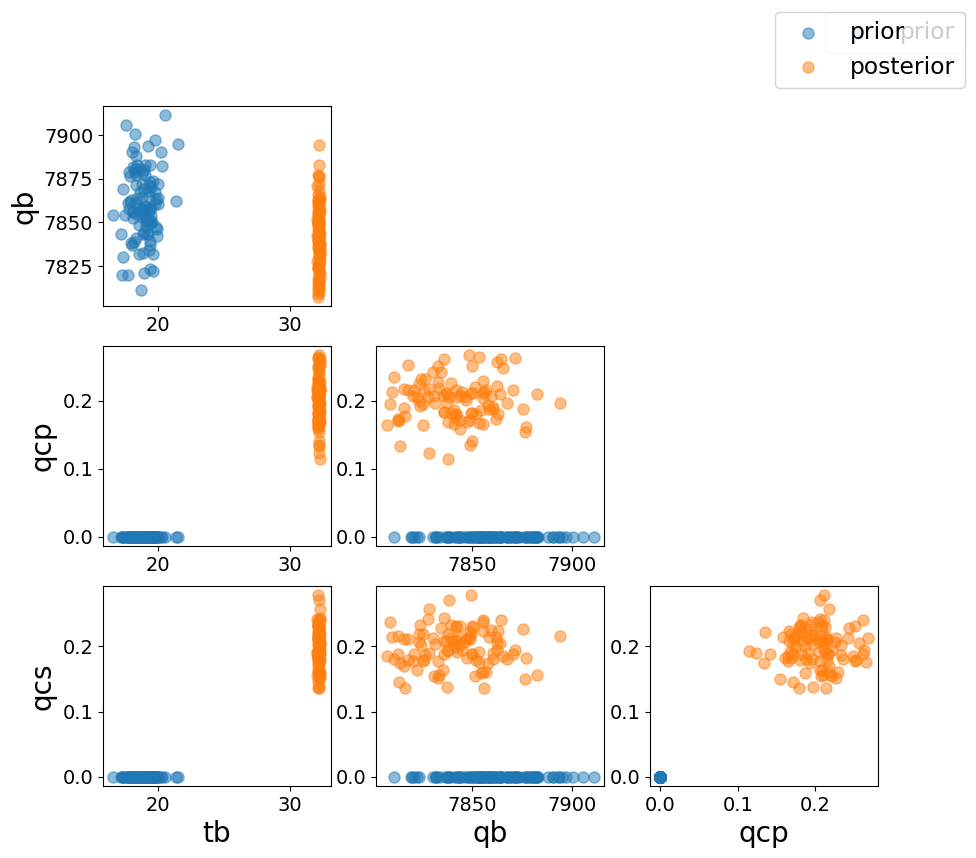

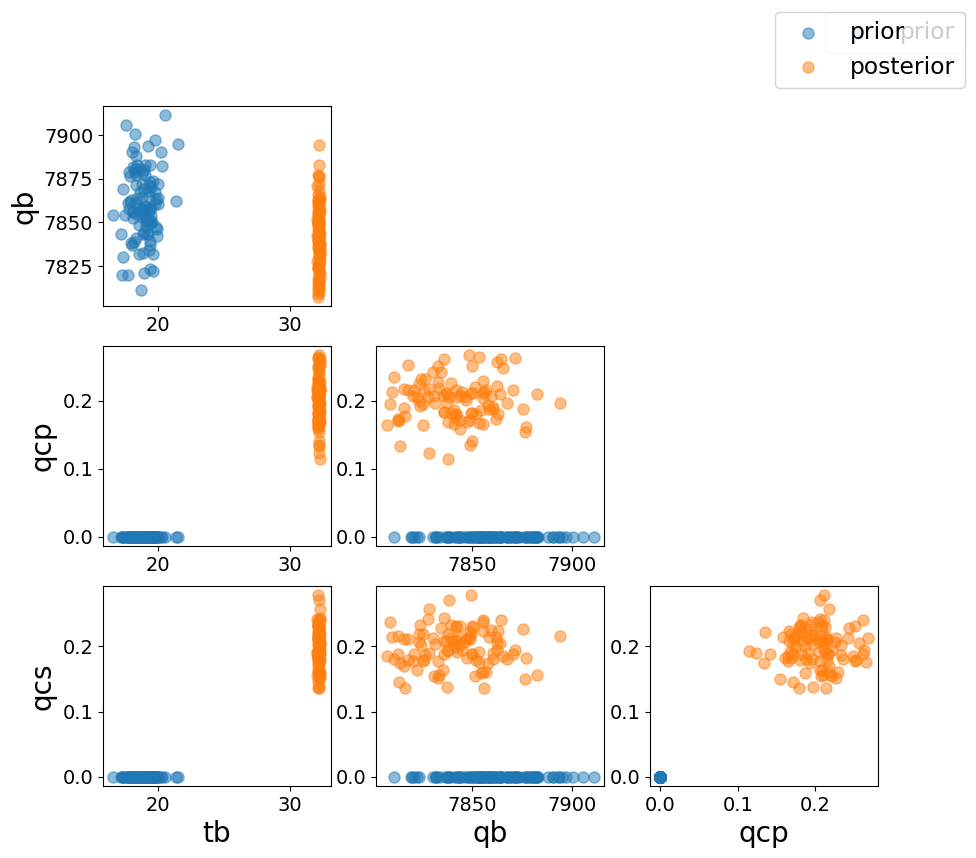

In [10]:
print("Prior State:", est.x.mean)
print('\tSOC: ', m.event_state(est.x.mean)['EOD'])
fig = est.x.plot_scatter(label='prior')

t = 0.1
u = m.InputContainer({'i': 2})
example_measurements = m.OutputContainer({'t': 32.2, 'v': 3.915})
est.estimate(t, u, example_measurements)

print("Posterior State:", est.x.mean)
print('\tSOC: ', m.event_state(est.x.mean)['EOD'])
est.x.plot_scatter(fig= fig, label='posterior')

As mentioned previously, this step is typically repeated when there's new data. filt.x may not be accessed every time the estimate is updated, only when it's needed.

## 3. 指标预测示例

Prediction is the practice of using a state estimation, a model, and estimates of future loading to predict future states and when an event will occur.

First we will import a predictor. In this case, we will use the MonteCarlo Predictor, but see documentation <https://nasa.github.io/prog_algs> for a full list of predictors and their configuration parameters.

In [11]:
from prog_algs.predictors import MonteCarlo

Next we initialize it using the model from the above example

In [12]:
mc = MonteCarlo(m)

Next, let's define future loading and the first state. The first state is the output of the state estimator, and the future loading scheme is a simple piecewise function

In [13]:
x = est.x  # The state estimate

def future_loading(t, x={}):
    # Variable (piece-wise) future loading scheme 
    if (t < 600):
        i = 2
    elif (t < 900):
        i = 1
    elif (t < 1800):
        i = 4
    elif (t < 3000):
        i = 2
    else:
        i = 3
    return m.InputContainer({'i': i})

Now let's use the constructed mc predictor to perform a single prediction. Here we're setting dt to 0.25. Note this may take up to a minute

In [14]:
mc_results = mc.predict(x, future_loading, dt=0.25, n_samples=20)

The predict function returns predictions of future inputs, states, outputs, and event_states at each save point. For sample-based predictors like the monte carlo, these can be accessed like an array with the format `[sample #][time]` so that `mc_results.states[m][n]` corresponds to the state for sample `m` at time `mc_results.times[m][n]`. Alternately, use the method `snapshot` to get a  single point in time. e.g., 

    `state = mc_results.states.snapshot(3)`

In this case the state snapshot corresponds to time `mc_results.times[3]`. The snapshot method returns type UncertainData. 

The `predict` method also returns Time of Event (ToE) as a type UncertainData, representing the predicted time of event (for each event predicted), with uncertainty.

Next, let's use the metrics package to analyze the ToE

In [ ]:
print("\nEOD Predictions (s):")
print('\tPortion between 3005.2 and 3005.6: ', mc_results.time_of_event.percentage_in_bounds([3005.2, 3005.6]))
print('\tAssuming ground truth 3005.25: ', mc_results.time_of_event.metrics(ground_truth = 3005.25))
from prog_algs.metrics import prob_success 
print('\tP(Success) if mission ends at 3005.25: ', prob_success(mc_results.time_of_event, 3005.25))

These analysis methods applied to ToE can also be applied to anything of type UncertainData (e.g., state snapshot). 

You can also visualize the results in a variety of different ways. For example, state transition

In [ ]:
fig = mc_results.states.snapshot(0).plot_scatter(label = "t={:.0f}".format(int(mc_results.times[0])))
for i in range(1, 4):
    index = int(len(mc_results.times)/4*i)
    mc_results.states.snapshot(index).plot_scatter(fig=fig, label = "t={:.0f}".format(mc_results.times[index]))
mc_results.states.snapshot(-1).plot_scatter(fig = fig, label = "t={:.0f}".format(int(mc_results.times[-1])))

Or time of event (ToE)

In [ ]:
fig = mc_results.time_of_event.plot_hist()

Note, for this event, there is only one event (End of Discharge). Many models have multiple events that can be predicted. For these models, ToE for each event is returned and can be analyzed.

Alternately, a specific event (or events) can be specified for prediction. See `examples.predict_specific_event` for more details.

Frequently the prediction step is run periodically, less often than the state estimator step

## Extending - Adding a new state estimator

New state estimators can be created by extending the state_estimator interface. As an example lets use a really dumb state estimator that adds random noise each step - and accepts the state that is closest. 

First thing we need to do is import the StateEstimator parent class

In [ ]:
from prog_algs.state_estimators.state_estimator import StateEstimator

Next we select how state will be represented. In this case there's no uncertainty- it's just one state, so we represent it as a scaler. Import the appropriate class

In [ ]:
from prog_algs.uncertain_data import ScalarData

Now we construct the class, implementing the functions of the state estimator template (`state_estimator_template.py`)

In [ ]:
import random 

class BlindlyStumbleEstimator(StateEstimator):
    def __init__(self, model, x0):
        self.m = model
        self.state = x0

    def estimate(self, t, u, z):
        # Generate new candidate state
        x2 = {key : float(value) + 10*(random.random()-0.5) for (key,value) in self.state.items()}

        # Calculate outputs
        z_est = self.m.output(self.state)
        z_est2 = self.m.output(x2)

        # Now score them each by how close they are to the measured z
        z_est_score = sum([abs(z_est[key] - z[key]) for key in self.m.outputs])
        z_est2_score = sum([abs(z_est2[key] - z[key]) for key in self.m.outputs])

        # Now choose the closer one
        if z_est2_score < z_est_score: 
            self.state = x2

    @property
    def x(self):
        return ScalarData(self.state)


Great, now let's try it out using the model from earlier. with an initial state of all 0s. It should slowly converge towards the correct state

In [ ]:
x0 = {key: 0 for key in m.states}
se = BlindlyStumbleEstimator(m, x0)

for i in range(25):
    u = m.InputContainer({'i': 0})
    z = m.OutputContainer({'t': 18.95, 'v': 4.183})
    se.estimate(i, u, z)
    print(se.x.mean)
    print("\tcorrect: {'tb': 18.95, 'qb': 7856.3254, 'qcp': 0, 'qcs': 0}")

## Extending - Adding a new Predictor

Like the example above with StateEstimators, Predictors can be extended by subclassing the Predictor class. Copy `predictor_template.py` as a starting point.

## Conclusion
This is just the basics, there's much more to learn. Please see the documentation at <https://nasa.github.io/prog_algs> and the examples in the `examples/` folder for more details on how to use the package, including:
* `examples.basic_example` : A basic Example using prog_algs for Prognostics 
* `examples.benchmarking_example` : An example benchmarking the performance of prognostics algorithms
* `examples.eol_event` : An example where a model has multiple events, but the user is only interested in predicting the time when the first event occurs (whatever it is).
* `examples.measurement_eqn_example` : An example where not every output is measured or measurements are not in the same format as outputs, so a measurement equation is defined to translate between outputs and what's measured. 
* `examples.new_state_estimator_example` : An example of extending StateEstimator to create a new state estimator class
* `examples.playback` : A full example performing prognostics using playback data.
* `examples.predict_specific_event` : An example where the model has multiple events, but the user is only interested in predicting a specific event (or events).
* `examples.thrown_object_example` : An example performing prognostics with the simplified ThrownObject model
* `examples.utpredictor` : An example using the Unscented Transform Predictor for prediction.

Thank you for trying out this tutorial. Open an issue on github (<https://github.com/nasa/prog_algs/issues>) or email Chris Teubert (christopher.a.teubert@nasa.gov) with any questions or issues.

Copyright © 2021 United States Government as represented by the Administrator of the National Aeronautics and Space Administration.  All Rights Reserved.